In [ ]:
# Install necessary libraries
import json
import pandas as pd
# from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib.colors import rgb_to_hsv
from scipy import stats

In [ ]:
# Mount:
# drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Read json file
def readJsonData(JSON_FILE_PATH):
  data = None
  try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

  except FileNotFoundError:
      print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
      print("Please check the file path and ensure Google Drive is correctly mounted.")
  except json.JSONDecodeError:
      print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")
  return data

# Preprocessing
def preprocessData(data):
  flat_data = []

  # Extract metadata for easy merging later
  session_metadata = data.get('metadata', {})
  session_name = session_metadata.get('sessionName', 'Unknown Session')

  # Iterate through each sample (color card)
  for sample in data.get('data', []):
      sample_number = sample.get('sampleNumber')

      # Iterate through each measurement (1 to 10) within that sample
      for capture_index, measurement in enumerate(sample.get('measurements', [])):

          # Create a dictionary for the current row
          row = {
              'session_name': session_name,
              'sample_number': sample_number,
              'capture_index': capture_index, # 0 to 9
              'lighting_condition': session_metadata.get('lightingCondition'),
              'reflective_surface': session_metadata.get('useReflectiveSurface'),

              # Sensor Data
              'pitch': measurement['angles']['pitch'],
              'roll': measurement['angles']['roll'],
          }

          # Extract Color Data (White and Color reticles, three radii each)

          # White Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'white_r{radius}_R'] = color_data['r']
              row[f'white_r{radius}_G'] = color_data['g']
              row[f'white_r{radius}_B'] = color_data['b']

          # Color Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'color_r{radius}_R'] = color_data['r']
              row[f'color_r{radius}_G'] = color_data['g']
              row[f'color_r{radius}_B'] = color_data['b']

          flat_data.append(row)

  # Convert the list of dictionaries to a Pandas DataFrame
  df = pd.DataFrame(flat_data)

  print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")
  return df

# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.
def displayDataFrameInfo(df):
  print("\n--- DataFrame Head (First 5 Rows) ---")
  print(df.head())

  print("\n--- DataFrame Information ---")
  print(df.info())

  # ### 3.1 Check Sensor Variability

  # This checks the pitch/roll stability across all 240 measurements.
  print("\n--- Sensor Angle Statistics ---")
  print(df[['pitch', 'roll']].describe())

In [ ]:
def correctByScaling(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b, RefOption = 'white'):
  if RefOption == 'white':
    scale_r = 255.0 / (ref_r if ref_r > 0 else 1.0)
    scale_g = 255.0 / (ref_g if ref_g > 0 else 1.0)
    scale_b = 255.0 / (ref_b if ref_b > 0 else 1.0)

    corr_r = np.clip(meas_r * scale_r, 0, 255).astype(int)
    corr_g = np.clip(meas_g * scale_g, 0, 255).astype(int)
    corr_b = np.clip(meas_b * scale_b, 0, 255).astype(int)

  elif RefOption == 'black':
    scale_factor = 255.0 / 50.0

    corr_r = np.clip(meas_r * scale_factor, 0, 255).astype(int)
    corr_g = np.clip(meas_g * scale_factor, 0, 255).astype(int)
    corr_b = np.clip(meas_b * scale_factor, 0, 255).astype(int)

  return corr_r, corr_g, corr_b

def apply_correction(row, color_prefix = 'white_r', radius = 4, correctionFunction = correctByScaling):
    # Get raw white reference (R4)
    ref_r = row['white_r' + str(radius) + '_R']
    ref_g = row['white_r' + str(radius) + '_G']
    ref_b = row['white_r' + str(radius) + '_B']

    # Get raw measured color (R4)
    meas_r = row[f'{color_prefix}_R']
    meas_g = row[f'{color_prefix}_G']
    meas_b = row[f'{color_prefix}_B']

    # Apply the correction function
    corr_factor_r, corr_factor_g, corr_factor_b = correctionFunction(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b)

    return pd.Series([corr_factor_r, corr_factor_g, corr_factor_b])

# Apply correction to the color R4 measurements using correctByScaling
def correctRGB(df, correctionFunction = correctByScaling):
  df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r0', radius = 0, correctionFunction=correctionFunction), axis=1
  )
  df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r2', radius = 2, correctionFunction=correctionFunction), axis=1
  )
  df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r4', radius = 4, correctionFunction=correctionFunction), axis=1
  )

  # print( df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']].describe())
  # print( df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']].describe())
  # print( df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']].describe())

In [ ]:
def rgb_to_hsv_overload(r, g, b):
    # Normalize R, G, B values to the range 0-1
    r_norm, g_norm, b_norm = map(lambda x: x/255, (r,g,b))

    # Calculate C_max, C_min, and delta
    C_max, C_min = max(r_norm, g_norm, b_norm), min(r_norm, g_norm, b_norm)
    delta = C_max - C_min

    # Calculate Hue (H)
    h = 0
    if delta > 0:
      if C_max == r_norm: h = 60 * (((g_norm - b_norm) / delta) % 6)
      elif C_max == g_norm: h = 60 * (((b_norm - r_norm) / delta) + 2)
      elif C_max == b_norm: h = 60 * (((r_norm - g_norm) / delta) + 4)

    # Ensure H is in the range [0, 360)
    if h < 0: h += 360

    # Calculate Saturation (S)
    s = delta / C_max if C_max > 0 else 0

    # Calculate Value (V)
    v = C_max

    return h, s, v

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

In [ ]:
def combineGroundTruth(df):
  ground_truth_data = [
      {'sample_number': 1,  'label': 'Dark Skin',      'gt__R': 115, 'gt__G': 82,  'gt__B': 69},
      {'sample_number': 2,  'label': 'Light Skin',     'gt__R': 204, 'gt__G': 161, 'gt__B': 141},
      {'sample_number': 3,  'label': 'Blue Sky',       'gt__R': 101, 'gt__G': 134, 'gt__B': 179},
      {'sample_number': 4,  'label': 'Foliage',        'gt__R': 89,  'gt__G': 109, 'gt__B': 61},
      {'sample_number': 5,  'label': 'Blue Flower',    'gt__R': 141, 'gt__G': 137, 'gt__B': 194},
      {'sample_number': 6,  'label': 'Bluish Green',   'gt__R': 132, 'gt__G': 228, 'gt__B': 208},
      {'sample_number': 7,  'label': 'Orange',         'gt__R': 249, 'gt__G': 118, 'gt__B': 35},
      {'sample_number': 8,  'label': 'Purplish Blue',  'gt__R': 80,  'gt__G': 91,  'gt__B': 182},
      {'sample_number': 9,  'label': 'Moderate Red',   'gt__R': 222, 'gt__G': 91,  'gt__B': 125},
      {'sample_number': 10, 'label': 'Purple',         'gt__R': 91,  'gt__G': 63,  'gt__B': 123},
      {'sample_number': 11, 'label': 'Yellow Green',   'gt__R': 173, 'gt__G': 232, 'gt__B': 91},
      {'sample_number': 12, 'label': 'Orange Yellow',  'gt__R': 255, 'gt__G': 164, 'gt__B': 26},
      {'sample_number': 13, 'label': 'Blue',           'gt__R': 44,  'gt__G': 56,  'gt__B': 142},
      {'sample_number': 14, 'label': 'Green',          'gt__R': 74,  'gt__G': 148, 'gt__B': 81},
      {'sample_number': 15, 'label': 'Red',            'gt__R': 179, 'gt__G': 42,  'gt__B': 50},
      {'sample_number': 16, 'label': 'Yellow',         'gt__R': 250, 'gt__G': 226, 'gt__B': 21},
      {'sample_number': 17, 'label': 'Magenta',        'gt__R': 191, 'gt__G': 81,  'gt__B': 160},
      {'sample_number': 18, 'label': 'Cyan',           'gt__R': 6,   'gt__G': 142, 'gt__B': 172},
      {'sample_number': 19, 'label': 'White',          'gt__R': 252, 'gt__G': 252, 'gt__B': 252},
      {'sample_number': 20, 'label': 'Neutral 8',      'gt__R': 230, 'gt__G': 230, 'gt__B': 230},
      {'sample_number': 21, 'label': 'Neutral 6.5',    'gt__R': 200, 'gt__G': 200, 'gt__B': 200},
      {'sample_number': 22, 'label': 'Neutral 5',      'gt__R': 143, 'gt__G': 143, 'gt__B': 142},
      {'sample_number': 23, 'label': 'Neutral 3.5',    'gt__R': 100, 'gt__G': 100, 'gt__B': 100},
      {'sample_number': 24, 'label': 'Black',          'gt__R': 50,  'gt__G': 50,  'gt__B': 50},
  ]
  df_gt = pd.DataFrame(ground_truth_data)
  df = pd.merge(df, df_gt, on='sample_number', how='outer')

  return df, df_gt

def generateFinalDataFrame(df_with_gt_columns):
  # Calculate average color and corrected color values per sample_number
  avg_cols_to_compute = [
      'color_r0_R', 'color_r0_G', 'color_r0_B',
      'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
      'color_r2_R', 'color_r2_G', 'color_r2_B',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
      'color_r4_R', 'color_r4_G', 'color_r4_B',
      'correction_r4_R', 'correction_r4_G', 'correction_r4_B'
  ]
  df_avg = df_with_gt_columns.groupby('sample_number')[avg_cols_to_compute].mean().reset_index()

  # Rename columns to 'avg_...' to clearly distinguish them
  new_avg_columns_map = {col: 'avg_' + col for col in avg_cols_to_compute}
  df_avg = df_avg.rename(columns=new_avg_columns_map)

  # Merge the df (which now has ground truth) with the averaged color data
  df_final_comparison = pd.merge(df_with_gt_columns, df_avg, on='sample_number', how='left')

  return df_final_comparison

In [ ]:
def pipeline(jsonFilePath, radius_choice='r4', correction_method_name=correctByScaling, output_color_space='RGB'):
  data = readJsonData(jsonFilePath)
  df = preprocessData(data)
  correctRGB(df, correction_method_name)
  df, _ = combineGroundTruth(df)

  # Convert original RGB values to HSV and add to DataFrame
  rgb_column_sets = [
      ('white', 'r0'), ('white', 'r2'), ('white', 'r4'),
      ('color', 'r0'), ('color', 'r2'), ('color', 'r4'),
      ('gt', '') # This entry needs to be fixed to match the new gt__R naming
  ]

  for prefix, radius in rgb_column_sets:
      # Special handling for ground truth to match the double underscore naming
      if prefix == 'gt':
          r_col, g_col, b_col = 'gt__R', 'gt__G', 'gt__B'
          h_col, s_col, v_col = 'gt__H', 'gt__S', 'gt__V'
      else:
          r_col, g_col, b_col = f'{prefix}_{radius}_R', f'{prefix}_{radius}_G', f'{prefix}_{radius}_B'
          h_col, s_col, v_col = f'{prefix}_{radius}_H', f'{prefix}_{radius}_S', f'{prefix}_{radius}_V'

      df[[h_col, s_col, v_col]] = df.apply(
          lambda row: rgb_to_hsv_overload(row[r_col], row[g_col], row[b_col]),
          axis=1, result_type='expand'
      )
  displayDataFrameInfo(df)
  return df

In [ ]:
def plot_comparison_grid(df_final_comparison, radius, rows=6, cols=4):
    # To ensure one plot per sample, we'll take unique sample_numbers and the first associated row
    # The 'avg_' and 'gt__' columns should be constant for all rows of a given sample_number after the new merge logic
    df_plot = df_final_comparison.drop_duplicates(subset=['sample_number']).reset_index(drop=True)

    num_samples = len(df_plot)
    print(f"Plotting {num_samples} unique samples for radius r{radius}.")

    if num_samples == 0:
        print(f"No data to plot for radius r{radius}.")
        return

    if num_samples != rows * cols:
        print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}). Plotting up to {rows * cols} samples.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for i, row_data in df_plot.iterrows():
        if i >= len(axes):
            break # Stop if we run out of subplots

        # Dynamically extract columns based on radius, now using the 'avg_' prefix for comparison plots
        uncorr_r, uncorr_g, uncorr_b = row_data[f'avg_color_r{radius}_R'], row_data[f'avg_color_r{radius}_G'], row_data[f'avg_color_r{radius}_B']
        corr_r, corr_g, corr_b = row_data[f'avg_correction_r{radius}_R'], row_data[f'avg_correction_r{radius}_G'], row_data[f'avg_correction_r{radius}_B']

        # Ground Truth remains the same
        gt_r, gt_g, gt_b = row_data['gt__R'], row_data['gt__G'], row_data['gt__B']
        label = row_data['label']
        sample_number = row_data['sample_number']

        # Normalize RGB values to 0-1 for imshow
        gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
        uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
        corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

        # Create the 100x100 image array for the 3-part comparison
        image = np.zeros((100, 100, 3))

        # Lower half (Ground Truth)
        image[50:100, 0:100] = gt_color_norm
        # Upper-left quarter (Uncorrected)
        image[0:50, 0:50] = uncorr_color_norm
        # Upper-right quarter (Corrected)
        image[0:50, 50:100] = corr_color_norm

        ax = axes[i]
        ax.imshow(image)

        # Add hex labels
        ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'R{radius} Comparison (Averaged): Ground Truth vs. Uncorrected vs. Corrected', y=0.98, fontsize=16)
    plt.show()

def plotAllRadius(df_final_comparison):
  for radius in [0, 2, 4]:
    plot_comparison_grid(df_final_comparison, radius)

In [ ]:
def plot_error_dist(df, r=2):
    fig, axs = plt.subplots(6, 4, figsize=(8, 10), sharey='all')
    for sample_idx in range(0, 24):
        sample_num = sample_idx + 1
        subset = df[df['sample_number'] == sample_num]
        ax = axs[sample_idx//4, sample_idx%4]
        # sns.violinplot(
        #     data = subset[[f'error_r{r}_R', f'error_r{r}_G', f'error_r{r}_B']],
        #     palette = ['red', 'green', 'blue'],
        #     inner=None,
        #     ax=ax
        # )
        sns.swarmplot(
            data = subset[[f'correction_r{r}_R', f'correction_r{r}_G', f'correction_r{r}_B']],
            palette=['red', 'green', 'blue'],
            size=2,
            alpha=0.5,
            ax=ax,
        )
        gt_R = subset['gt__R'].values[0]
        gt_G = subset['gt__G'].values[0]
        gt_B = subset['gt__B'].values[0]
        width = 0.5
        center_R = 0
        center_G = 1
        center_B = 2
        ax.hlines(gt_R, xmin=center_R - width/2, xmax=center_R + width/2, colors='red', linestyles='dashed')
        ax.hlines(gt_G, xmin=center_G - width/2, xmax=center_G + width/2, colors='green', linestyles='dashed')
        ax.hlines(gt_B, xmin=center_B - width/2, xmax=center_B + width/2, colors='blue', linestyles='dashed')
        ax.set_title(
            f'Color {sample_num}',
            color=(gt_R/255, gt_G/255, gt_B/255),
            bbox=dict(facecolor='black')
        )
        ax.set_xticks([])
        ax.set_ylim(0, 256)
    #session_name = df['session_name'].values[0]
    #fig.suptitle(f'session = {session_name}, r = {r}')
    fig.supylabel('corrected RGB - true RGB')
    fig.tight_layout()
    return fig, axs

In [ ]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors
def df_HSV(df_final_comparison):
  df_final_comparison[['gt__H', 'gt__S', 'gt__V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Uncorrected colors
  df_final_comparison[['uncorr_H', 'uncorr_S', 'uncorr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['color_r2_R'], row['color_r2_G'], row['color_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Corrected colors
  df_final_comparison[['corr_H', 'corr_S', 'corr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  df_final_comparison['H_error_uncorr'] = df_final_comparison['uncorr_H'] - df_final_comparison['gt__H']
  df_final_comparison['H_error_corr'] = df_final_comparison['corr_H'] - df_final_comparison['gt__H']

  df_final_comparison['S_error_uncorr'] = df_final_comparison['uncorr_S'] - df_final_comparison['gt__S']
  df_final_comparison['S_error_corr'] = df_final_comparison['corr_S'] - df_final_comparison['gt__S']

  df_final_comparison['V_error_uncorr'] = df_final_comparison['uncorr_V'] - df_final_comparison['gt__V']
  df_final_comparison['V_error_corr'] = df_final_comparison['corr_V'] - df_final_comparison['gt__V']
  return df_final_comparison

In [ ]:
# Define the HSV components to plot
def plotHSV(df_final_comparison):
  hsv_components = ['H', 'S', 'V']

  for component in hsv_components:
      plt.figure(figsize=(10, 6))

      # Uncorrected error column name
      uncorr_error_col = f'{component}_error_uncorr'
      # Corrected error column name
      corr_error_col = f'{component}_error_corr'

      # Plot uncorrected error distribution
      sns.kdeplot(x=df_final_comparison[uncorr_error_col],
              fill=True,
              color='blue',
              label='Uncorrected',
              alpha=0.2,
              common_norm=False)

      # Plot corrected error distribution
      #sns.histplot(df_final_comparison[corr_error_col], kde=True, color='red', label='Corrected', alpha=0.6, stat='density', common_norm=False)

      sns.kdeplot(x=df_final_comparison[corr_error_col],
              fill=True,
              color='red',
              label='Corrected',
              alpha=0.2,
              common_norm=False)

      # Calculate mean and standard deviation for both distributions
      mean_uncorr = df_final_comparison[uncorr_error_col].mean()
      std_uncorr = df_final_comparison[uncorr_error_col].std()

      mean_corr = df_final_comparison[corr_error_col].mean()
      std_corr = df_final_comparison[corr_error_col].std()

      # Add text annotations for mean and std dev
      plt.axvline(mean_uncorr, color='blue', linestyle='dashed', linewidth=1)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.9, f'Mean Uncorr: {mean_uncorr:.3f}', color='blue', fontsize=10)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.85, f'Std Uncorr: {std_uncorr:.3f}', color='blue', fontsize=10)

      plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.75, f'Mean Corr: {mean_corr:.3f}', color='red', fontsize=10)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.7, f'Std Corr: {std_corr:.3f}', color='red', fontsize=10)

      # Set title and labels
      plt.title(f'Distribution of {component} Error: Uncorrected vs. Corrected')
      plt.xlabel('Error Value')
      plt.ylabel('Density')
      plt.legend()
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


Processing all JSON files in directory: /content/drive/MyDrive/Colorimeter/Data/
  Processing: /content/drive/MyDrive/Colorimeter/Data/Tai2.json
✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : Tai2
lightingCondition   : 4
useReflectiveSurface: False
dateTime            : 2025-11-19T16:09:56.487180

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).

--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0         Tai2              1              0                   4   
1         Tai2              1              1                   4   
2         Tai2              1              2                   4   
3         Tai2              1              3                   4   
4         Tai2              1              4                   4   

   reflective_surface      pitch       roll  white_r0_R  white_r0_G  \
0               False  14.663107  -1.947957    

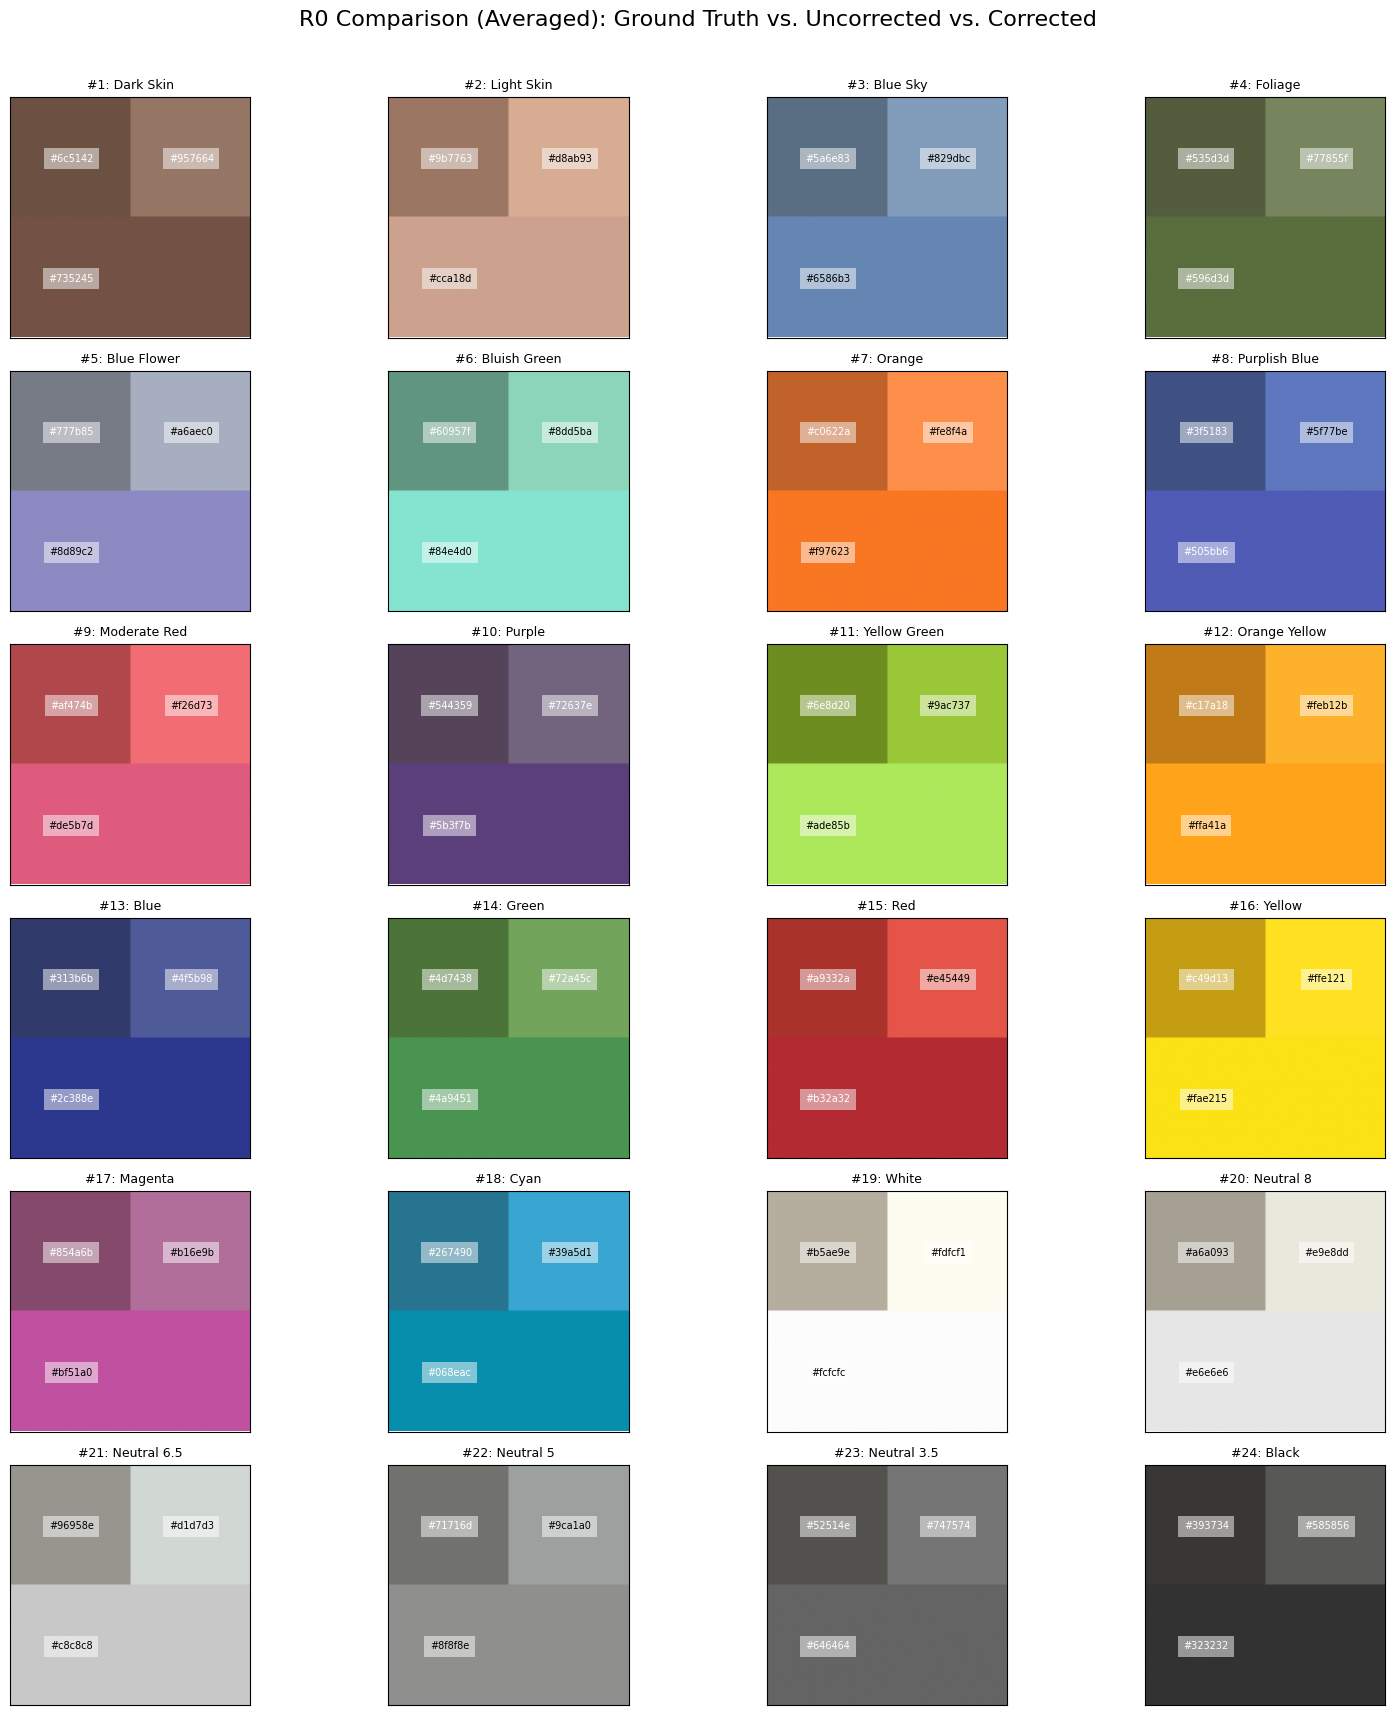

Plotting 24 unique samples for radius r2.


Plotting 24 unique samples for radius r4.


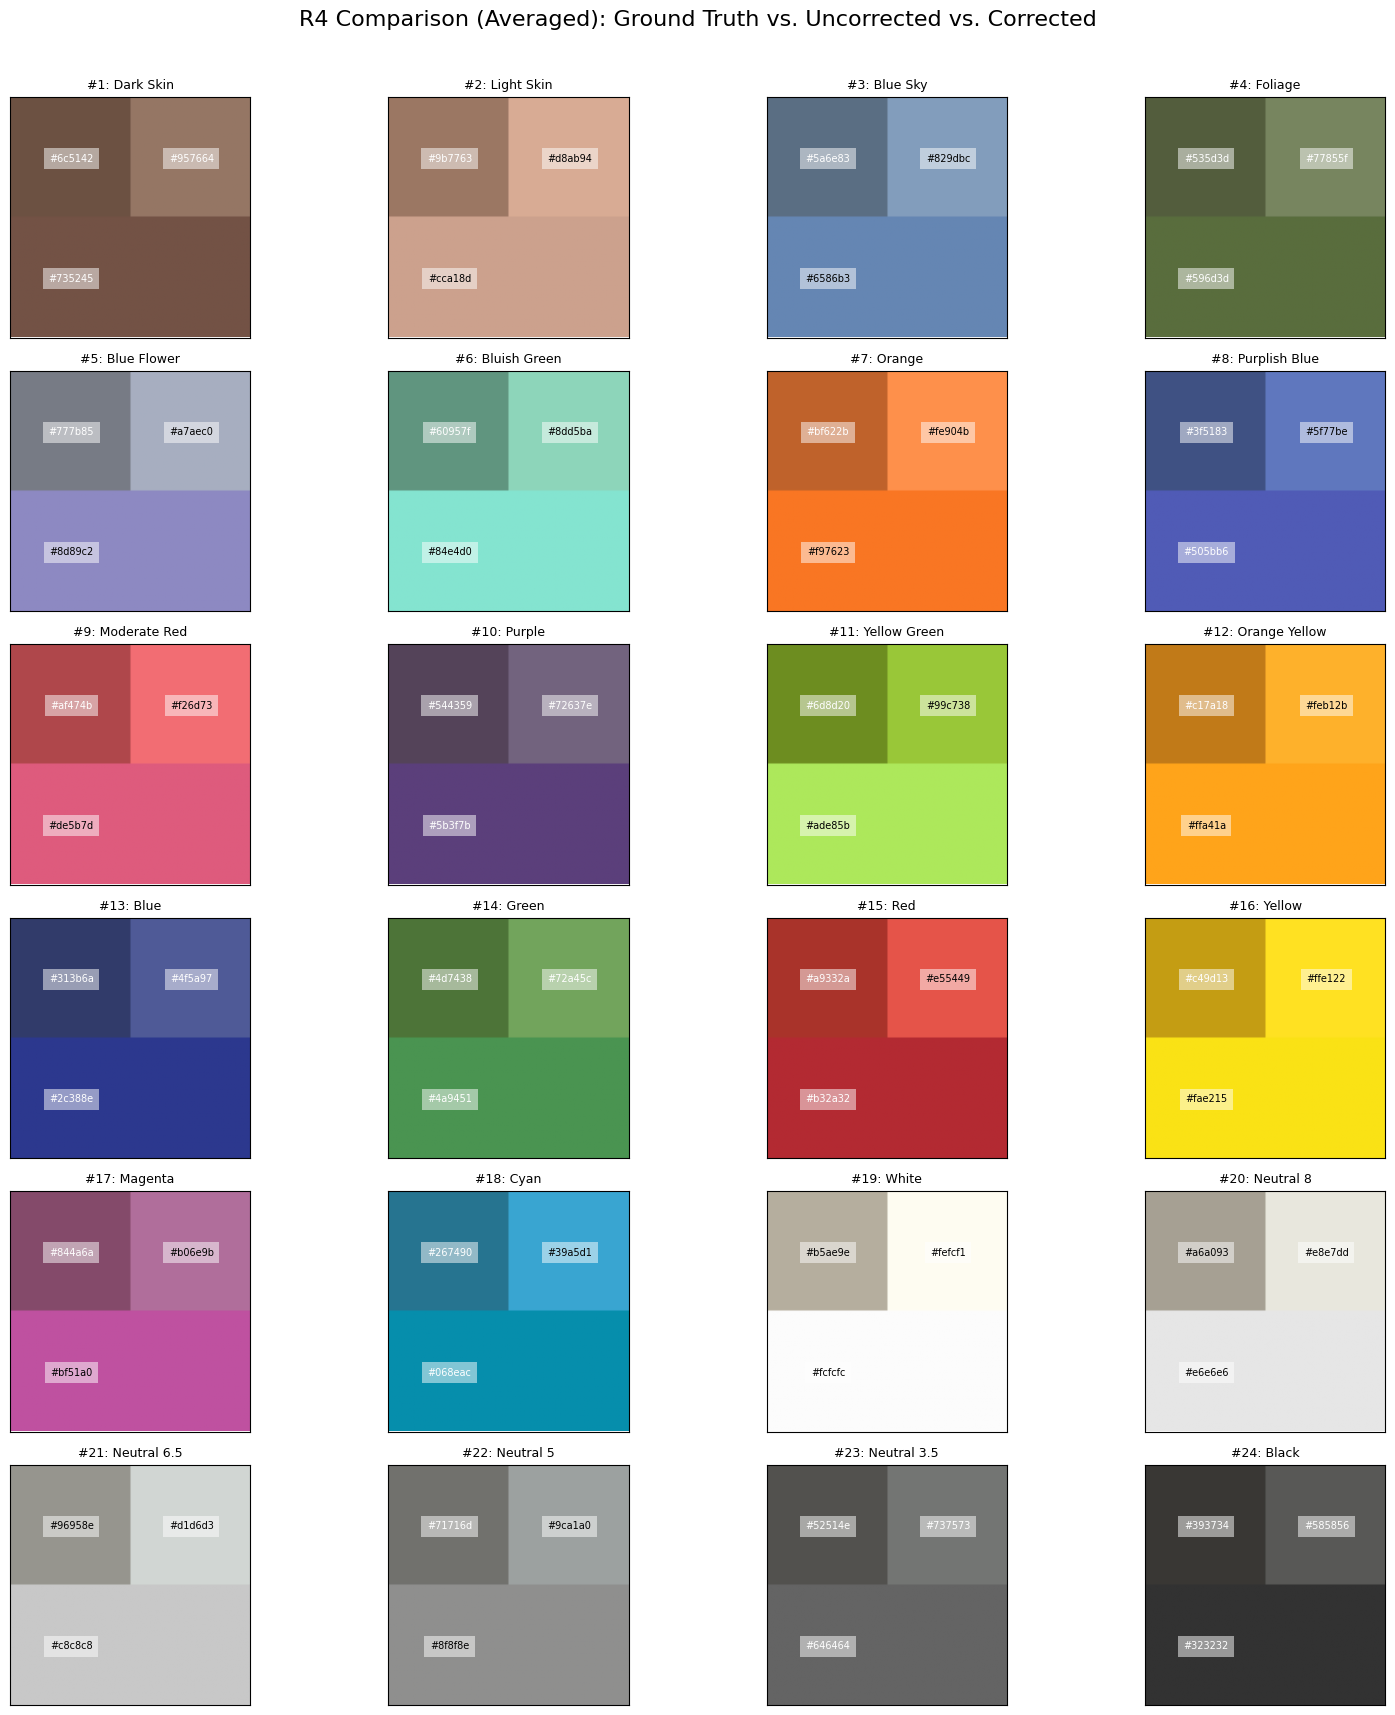

In [ ]:
def process_colorimeter_data(input_path, correction_method_name):
    all_dfs = []

    if os.path.isfile(input_path) and input_path.endswith('.json'):
        print(f"Processing single file: {input_path}")
        df_single = pipeline(input_path, correction_method_name=correction_method_name)
        all_dfs.append(df_single)
    elif os.path.isdir(input_path):
        print(f"Processing all JSON files in directory: {input_path}")
        for filename in os.listdir(input_path):
            if filename.endswith('.json'):
                json_file_path = os.path.join(input_path, filename)
                print(f"  Processing: {json_file_path}")
                df_current = pipeline(json_file_path, correction_method_name=correction_method_name)
                all_dfs.append(df_current)
    else:
        print(f"Invalid input path: {input_path}. Please provide a valid JSON file or directory containing JSON files.")
        return pd.DataFrame() # Return an empty DataFrame for invalid input

    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame() # Return empty DataFrame if no files processed


corrected_function = partial(correctByScaling, RefOption = 'white')

# User choice: provide a single file path or a directory path
# Uncomment ONE of the lines below:

# For a single file:
input_data_path = '/content/drive/MyDrive/Colorimeter/Data/Tai1.json'
# For all files in a directory (make sure the directory exists and contains JSON files):
# input_data_path = '/content/drive/MyDrive/Colorimeter/Data'

df = process_colorimeter_data(input_data_path, correction_method_name=corrected_function)

if not df.empty:
    df = generateFinalDataFrame(df)
    plotAllRadius(df)
    #fig, axs = plot_error_dist(df, r=2)
    df = df_HSV(df)
    plotHSV(df)
else:
    print("No data processed. Please check the input path and file(s).")

✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : Tai3
lightingCondition   : 6
useReflectiveSurface: False
dateTime            : 2025-11-19T16:55:37.276624

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).

--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0         Tai3              1              0                   6   
1         Tai3              1              1                   6   
2         Tai3              1              2                   6   
3         Tai3              1              3                   6   
4         Tai3              1              4                   6   

   reflective_surface      pitch       roll  white_r0_R  white_r0_G  \
0               False  15.563488   3.891531         192         183   
1               False  18.183373  16.294613         192         183   
2               False  19.623264  26.174620       

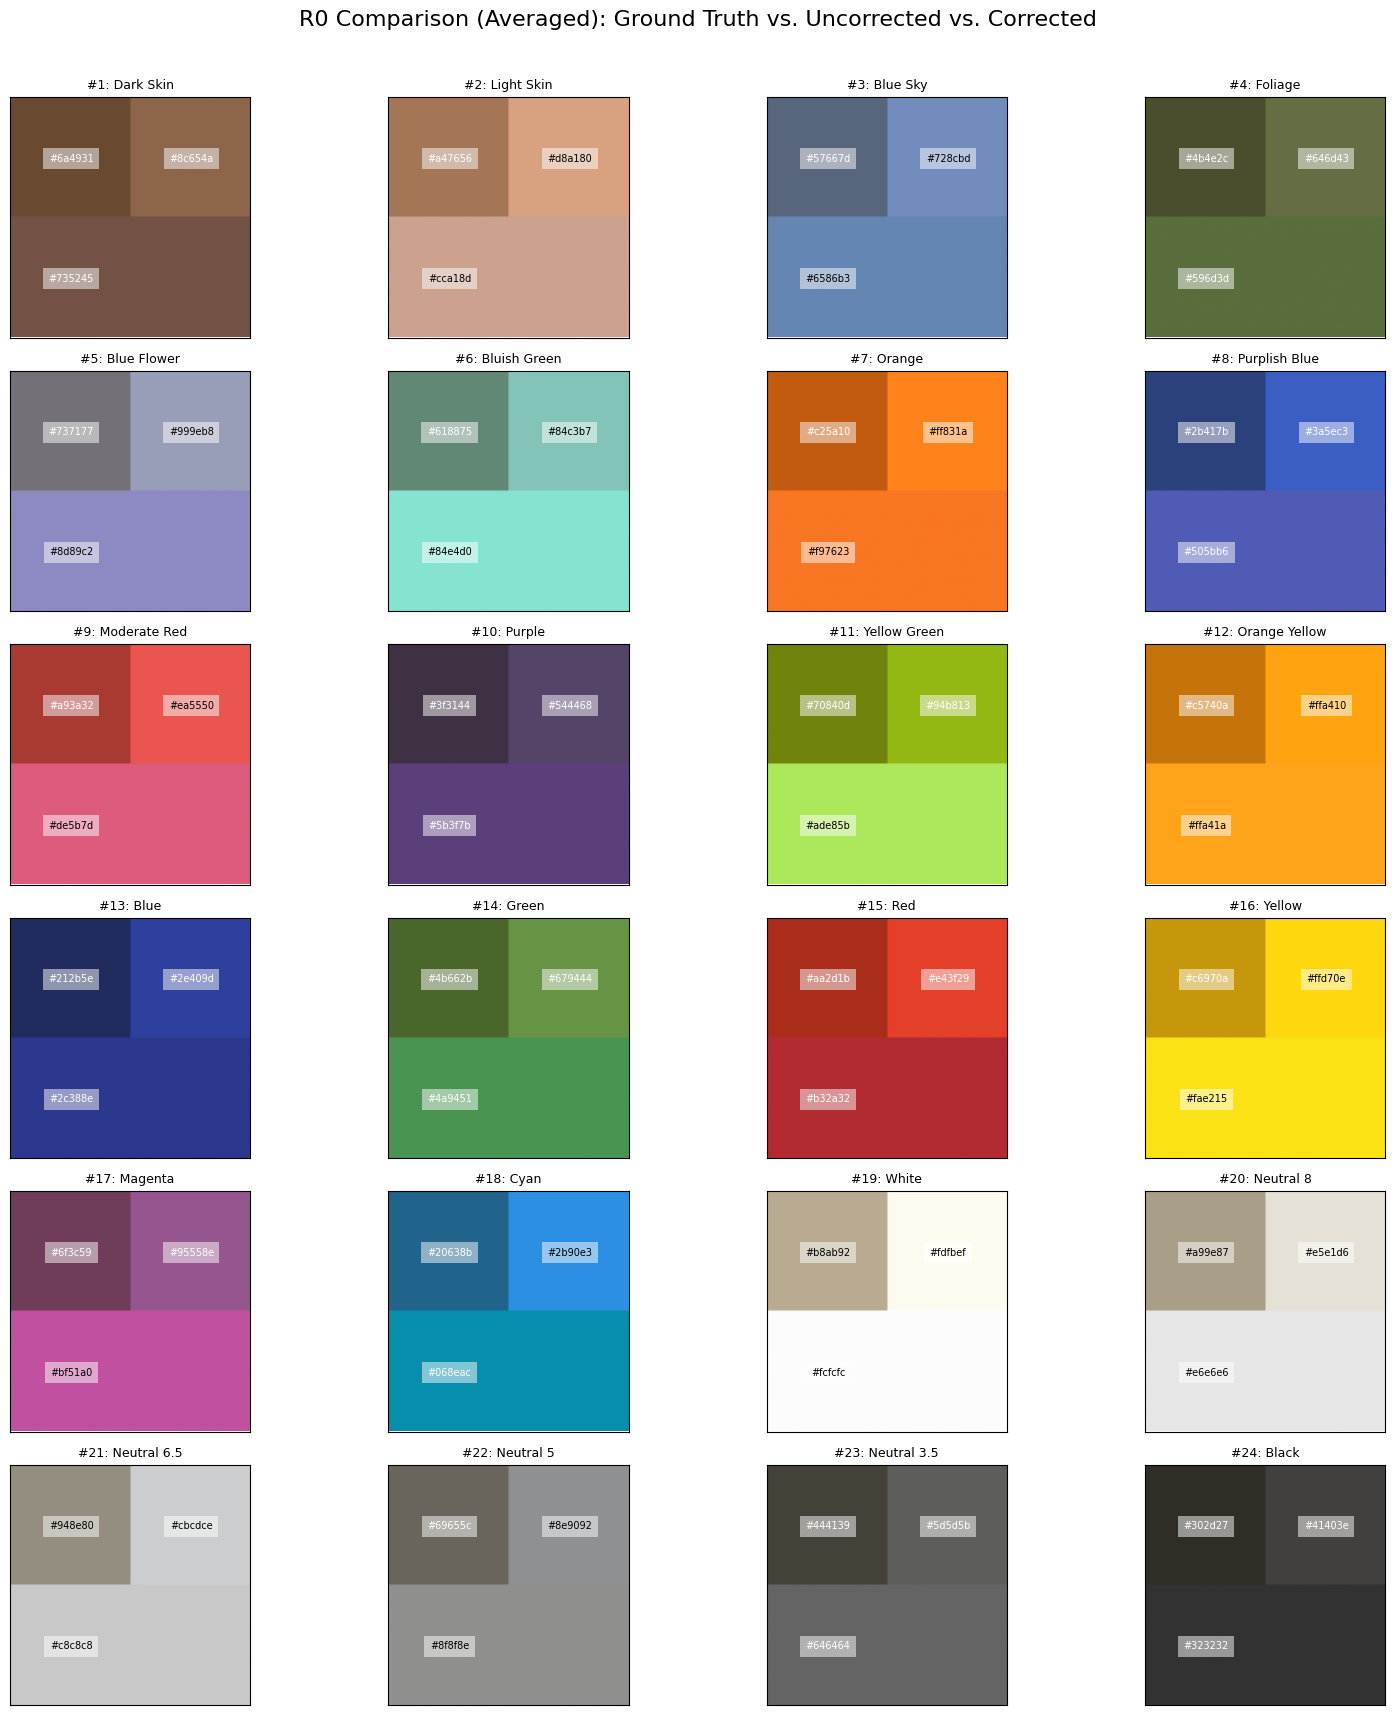

Plotting 24 unique samples for radius r2.


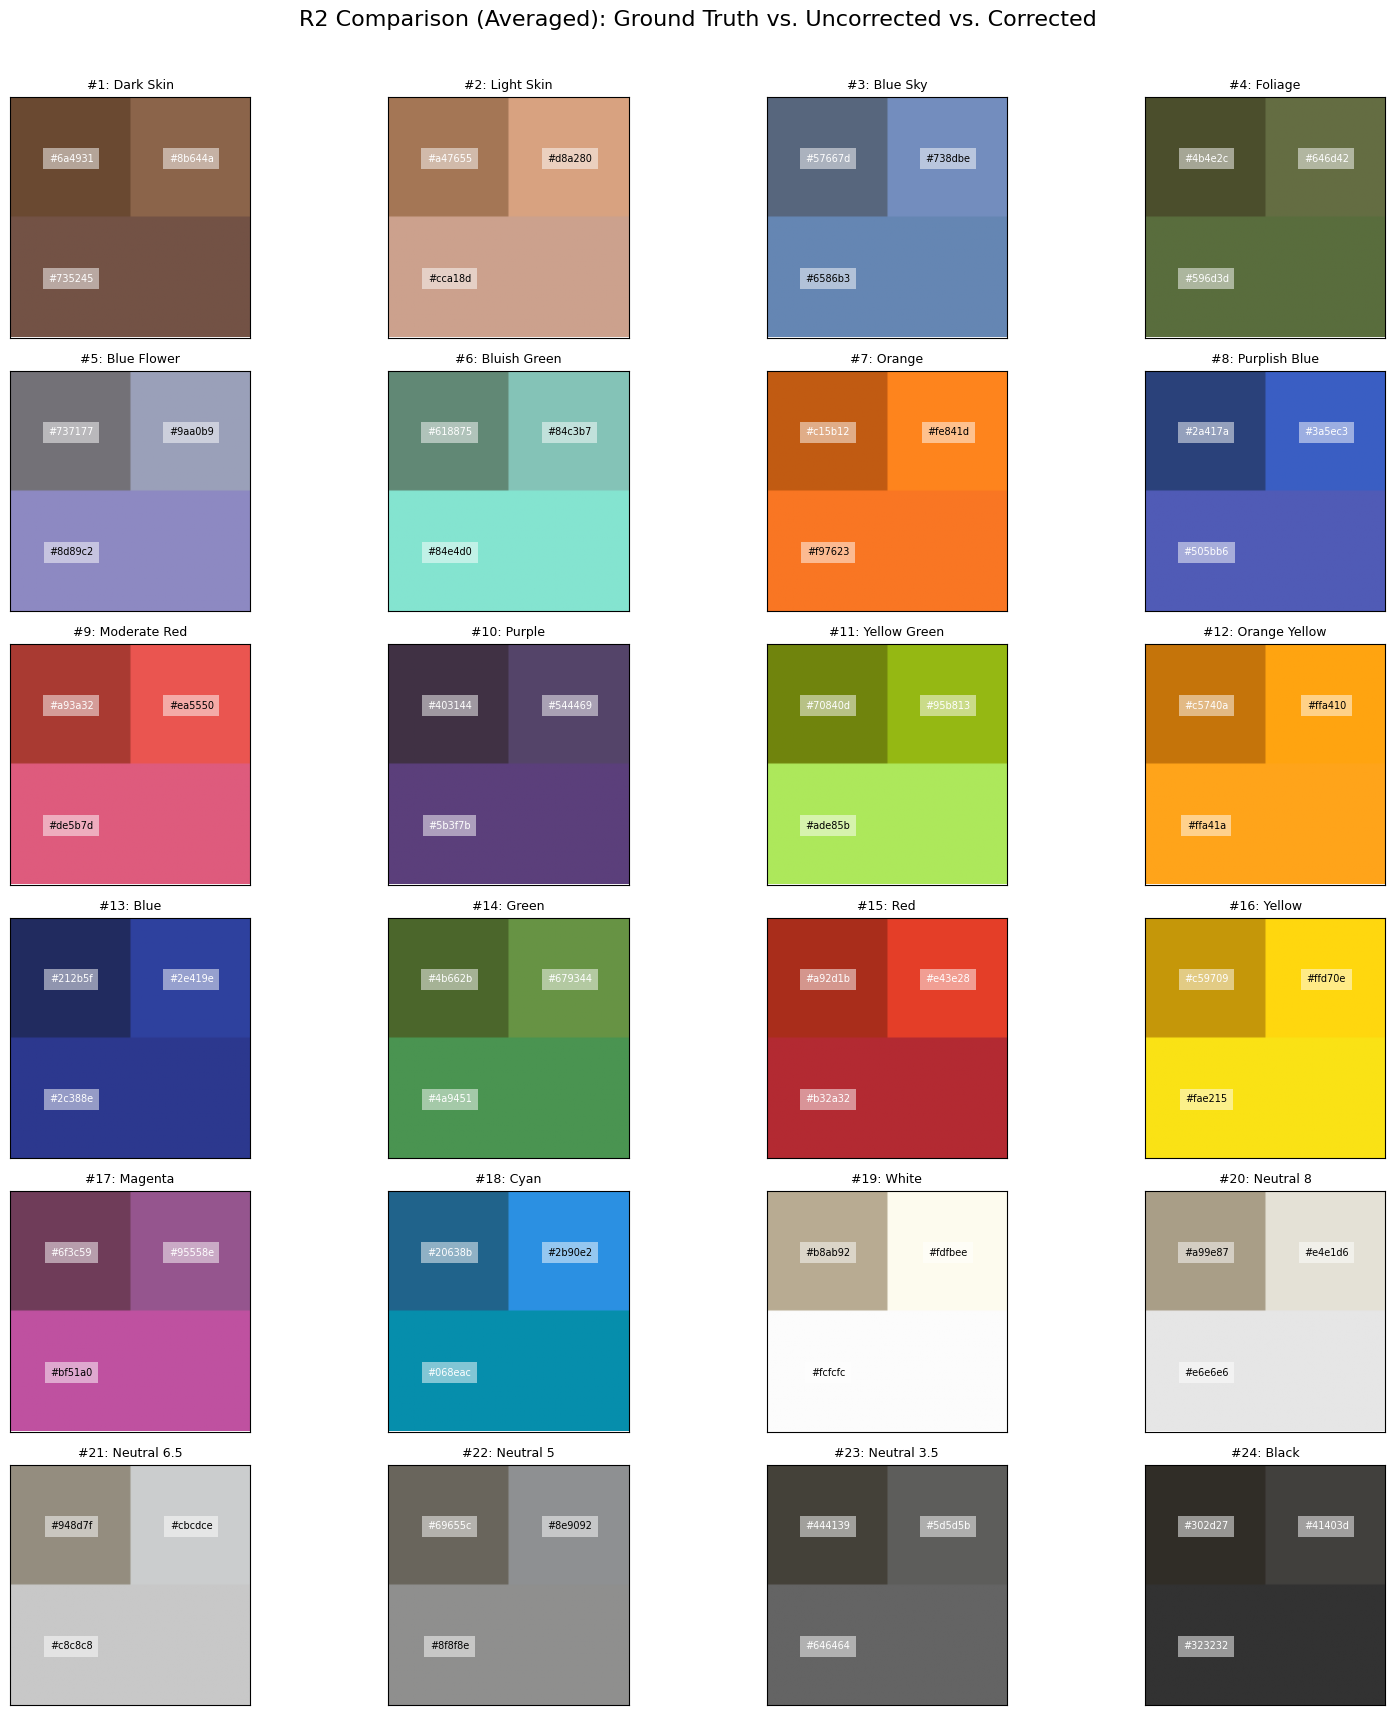

Plotting 24 unique samples for radius r4.


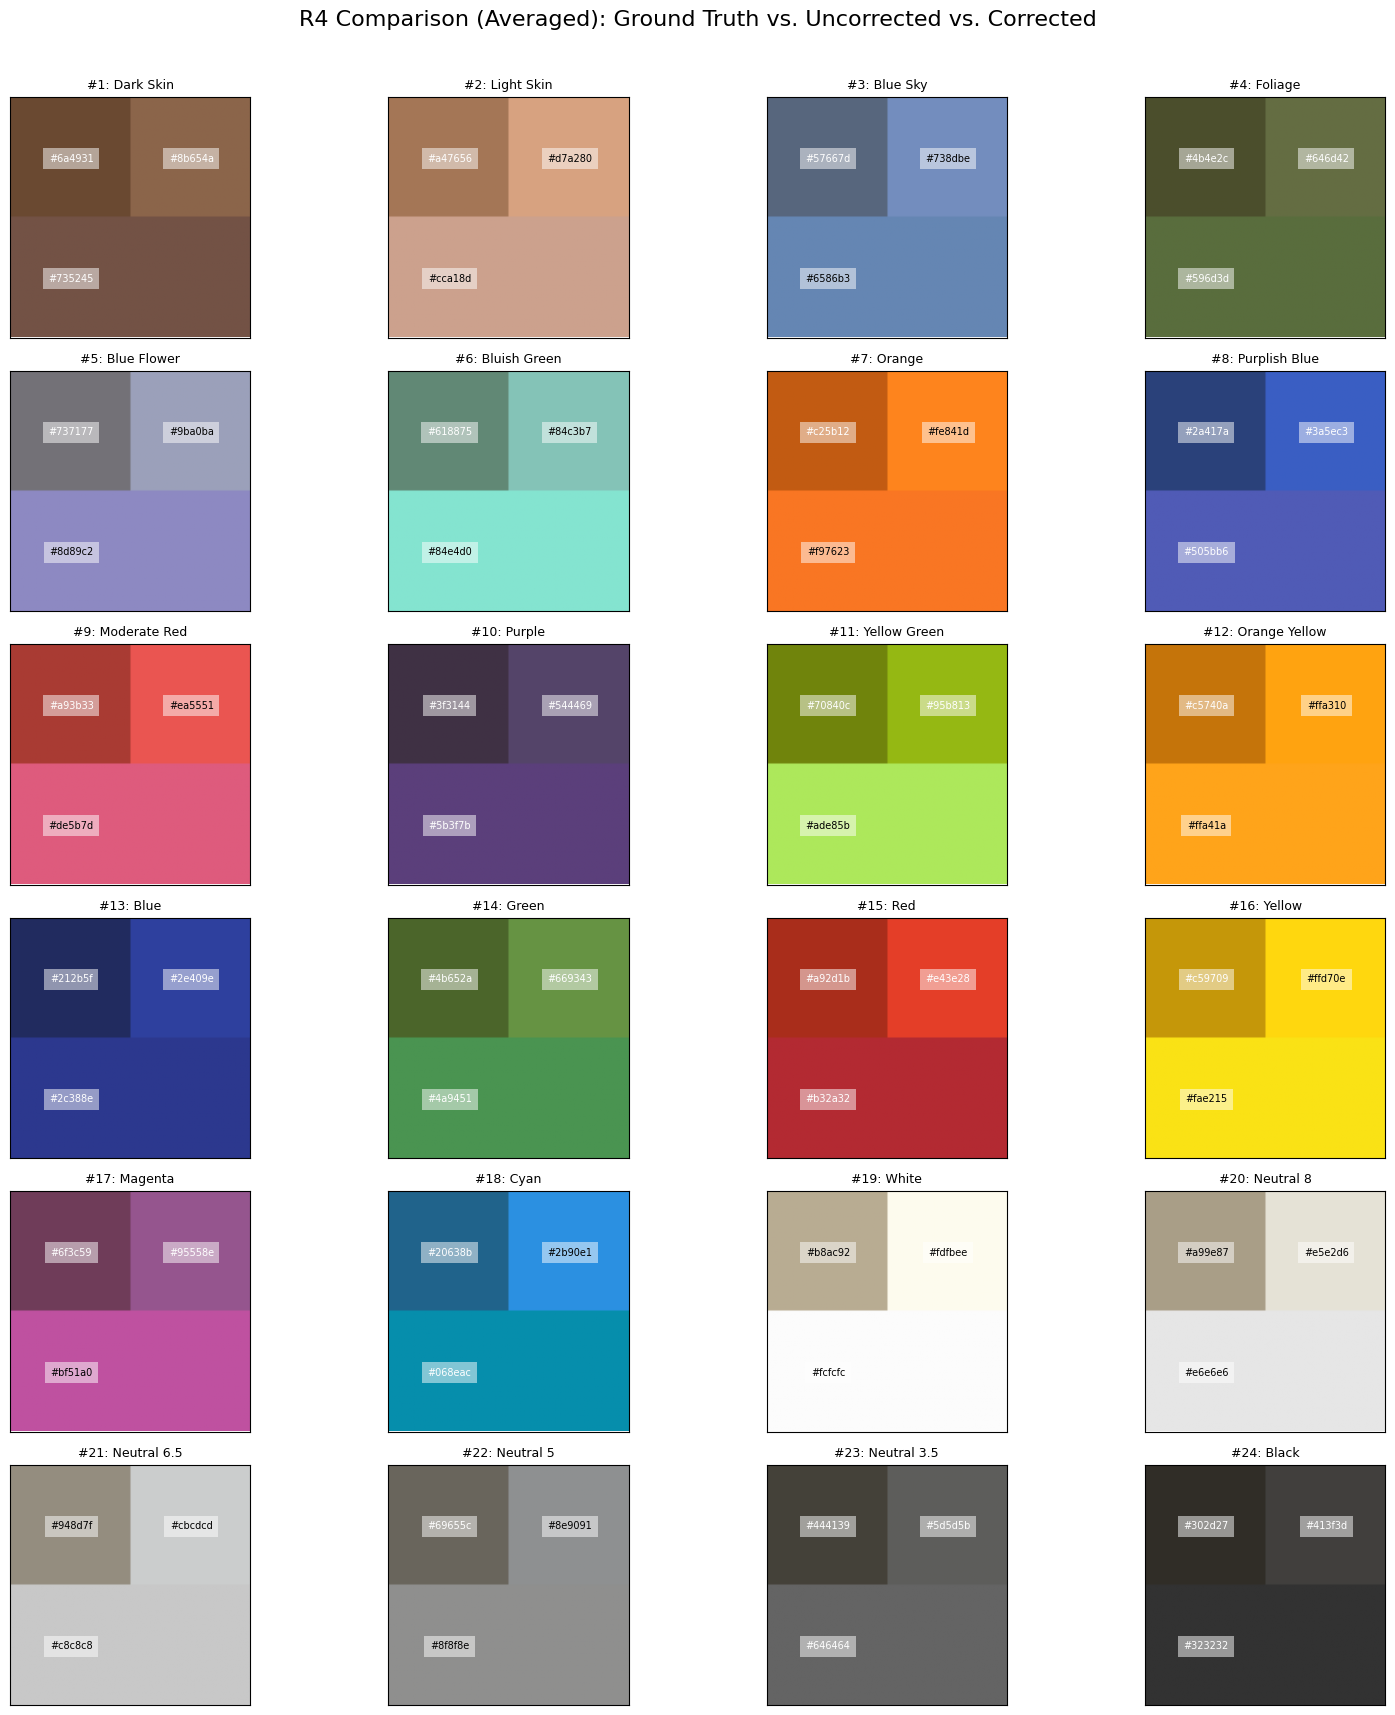

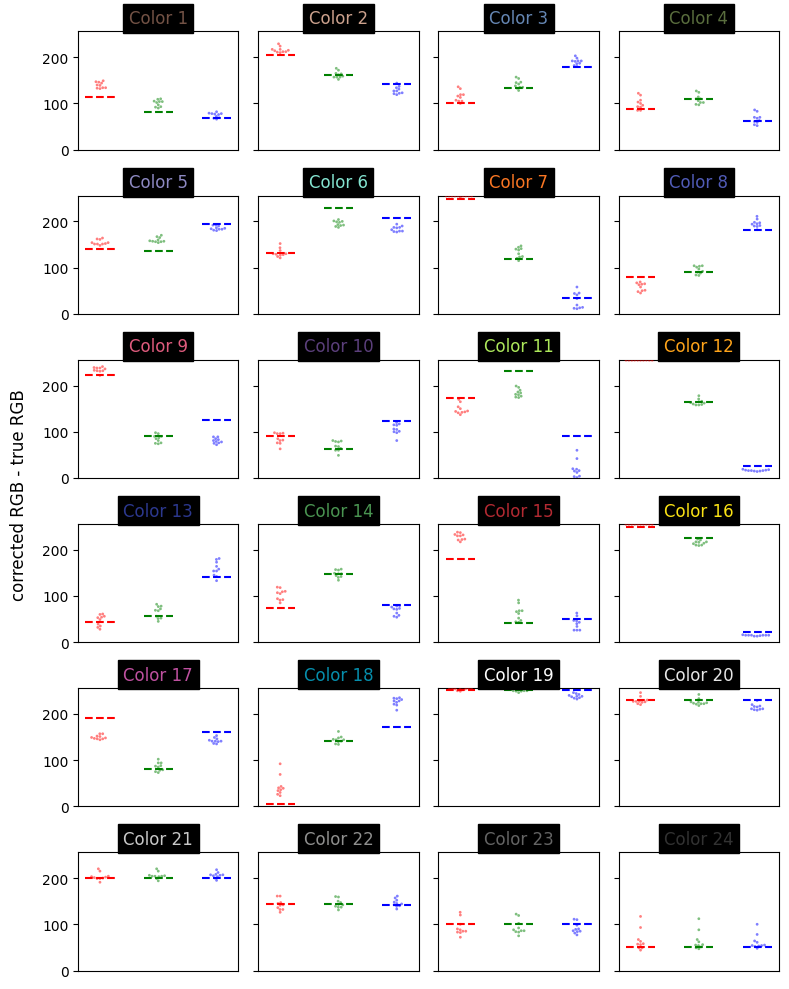

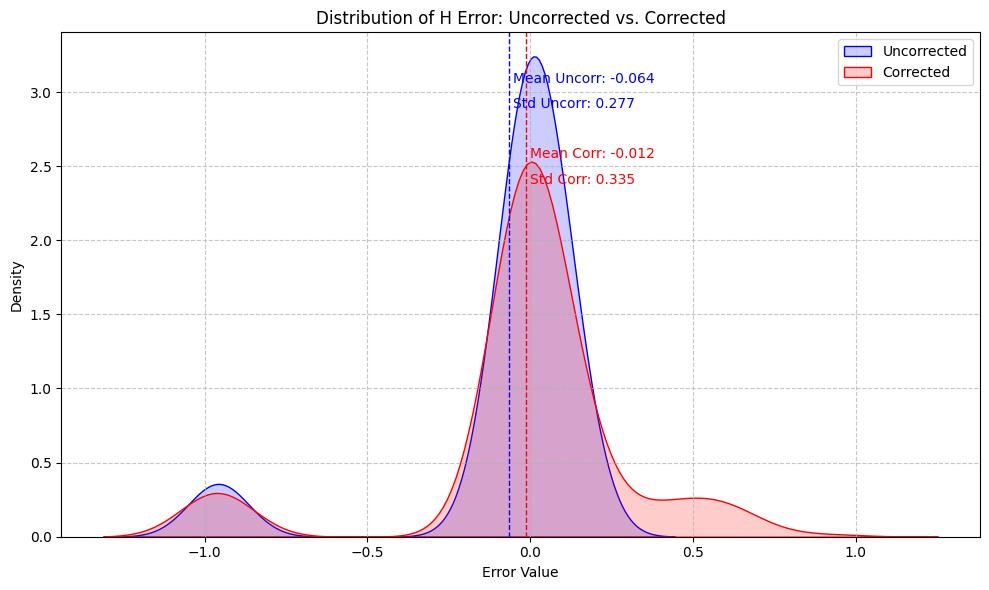

In [ ]:
# corrected_function = partial(correctByScaling, RefOption='white')
# df = pipeline('/content/drive/MyDrive/Colorimeter/Data/Tai3.json', correction_method_name = corrected_function)
# df = generateFinalDataFrame(df)
# plotAllRadius(df)
# fig, axs = plot_error_dist(df, r=2)
# df = df_HSV(df)
# plotHSV(df)

In [ ]:
def findSmallPump(df_final_comparison):
  print("### Data points with Uncorrected H Error between -1.5 and -0.5:")
  uncorr_h_error_filtered = df_final_comparison[(df_final_comparison['H_error_uncorr'] >= -1.5) & (df_final_comparison['H_error_uncorr'] <= -0.5)]
  display(uncorr_h_error_filtered[['sample_number', 'label', 'H_error_uncorr', 'H_error_corr']])

  print("\n### Data points with Corrected H Error between -1.5 and -0.5:")
  corr_h_error_filtered = df_final_comparison[(df_final_comparison['H_error_corr'] >= -1.5) & (df_final_comparison['H_error_corr'] <= -0.5)]
  display(corr_h_error_filtered[['sample_number', 'label', 'H_error_uncorr', 'H_error_corr']])
findSmallPump(df)

### Data points with Uncorrected H Error between -1.5 and -0.5:


sample_number label  H_error_uncorr  H_error_corr
140              15   Red       -0.989149     -0.927768
141              15   Red       -0.989142     -0.990268
143              15   Red       -0.990268     -0.990268
145              15   Red       -0.990268     -0.990268
147              15   Red       -0.990268     -0.990268
...             ...   ...             ...           ...
1825             15   Red       -0.974064     -0.975433
1826             15   Red       -0.968277     -0.969985
1827             15   Red       -0.968991     -0.971142
1828             15   Red       -0.969141     -0.970969
1829             15   Red       -0.972537     -0.974395

[114 rows x 4 columns]


### Data points with Corrected H Error between -1.5 and -0.5:


sample_number     label  H_error_uncorr  H_error_corr
20                3  Blue Sky       -0.015073     -0.596154
21                3  Blue Sky       -0.016987     -0.596154
22                3  Blue Sky       -0.019913     -0.596154
23                3  Blue Sky       -0.018232     -0.596154
24                3  Blue Sky       -0.021368     -0.596154
...             ...       ...             ...           ...
1825             15       Red       -0.974064     -0.975433
1826             15       Red       -0.968277     -0.969985
1827             15       Red       -0.968991     -0.971142
1828             15       Red       -0.969141     -0.970969
1829             15       Red       -0.972537     -0.974395

[157 rows x 4 columns]

In [ ]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV. rgb_to_hsv expects a single pixel, so we pass a 1D array.
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

def plotHSVError(option = 'V'):
  # Create a figure with two subplots side-by-side
  fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 2 columns

  # Get the error column name based on the option
  error_col = f'individual_{option}_error_corr'

  # Create a palette mapping labels to their ground truth hex colors
  # Ensure df['gt_hex_color'] is available (created in HSV_error function)
  label_color_map = df[['label', 'gt_hex_color']].drop_duplicates().set_index('label')['gt_hex_color'].to_dict()

  # Plot individual error against pitch on the first subplot
  sns.scatterplot(x='pitch', y=error_col, hue='label', data=df, ax=axes[0],
                  alpha=0.6, s=50, palette=label_color_map, legend='full') # Use custom palette

  # Add regression line
  sns.regplot(x='pitch', y=error_col, data=df, scatter=False, color='red',
              line_kws={'linestyle':'--', 'alpha':0.7, 'lw':2}, ax=axes[0]) # Line color red
  axes[0].set_title(f'Individual Corrected {option} Error vs. Pitch Angle')
  axes[0].set_xlabel('Pitch Angle (degrees)')
  axes[0].set_ylabel(f'Corrected {option} Error (Corrected {option} - Ground Truth {option})')
  axes[0].grid(True, linestyle='--', alpha=0.7)
  # Move legend outside for clarity
  axes[0].legend(title='Sample Label', bbox_to_anchor=(1.05, 1), loc='upper left')

  # Plot individual error against roll on the second subplot
  sns.scatterplot(x='roll', y=error_col, hue='label', data=df, ax=axes[1],
                  alpha=0.6, s=50, palette=label_color_map, legend=False) # Use custom palette, no legend on second plot

  # Add regression line
  sns.regplot(x='roll', y=error_col, data=df, scatter=False, color='red',
              line_kws={'linestyle':'--', 'alpha':0.7, 'lw':2}, ax=axes[1]) # Line color red
  axes[1].set_title(f'Individual Corrected {option} Error vs. Roll Angle')
  axes[1].set_xlabel('Roll Angle (degrees)')
  axes[1].set_ylabel(f'Corrected {option} Error (Corrected {option} - Ground Truth {option})')
  axes[1].grid(True, linestyle='--', alpha=0.7)
  # No legend needed here, as the first subplot has it.

  plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to prevent legend overlap
  plt.show()

# Apply to Ground Truth colors in df
def HSV_error(df):
  df[['gt_H_individual', 'gt_S_individual', 'gt_V_individual']] = df.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Add gt_hex_color column
  df['gt_hex_color'] = df.apply(lambda row: rgb_to_hex(row['gt__R'], row['gt__G'], row['gt__B']), axis=1)

  # Apply to Corrected colors in df
  df[['corrected_r2_H_individual', 'corrected_r2_S_individual', 'corrected_r2_V_individual']] = df.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  print("### Head of DataFrame with new individual HSV columns:")
  print(df[[
      'sample_number', 'capture_index',
      'gt__R', 'gt__G', 'gt__B', 'gt_H_individual', 'gt_S_individual', 'gt_V_individual',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B', 'corrected_r2_H_individual', 'corrected_r2_S_individual', 'corrected_r2_V_individual'
  ]].head())

  # Value error
  df['individual_V_error_corr'] = df['corrected_r2_V_individual'] - df['gt_V_individual']

  print("### Head of DataFrame with new individual_V_error_corr column:\n")
  print(df[['sample_number', 'capture_index', 'gt_V_individual', 'corrected_r2_V_individual', 'individual_V_error_corr']].head())

  correlation_pitch_V_error = df['individual_V_error_corr'].corr(df['pitch'])
  correlation_roll_V_error = df['individual_V_error_corr'].corr(df['roll'])

  print(f"Pearson correlation between individual_V_error_corr and pitch: {correlation_pitch_V_error:.4f}")
  print(f"Pearson correlation between individual_V_error_corr and roll: {correlation_roll_V_error:.4f}")
  plotHSVError('V')


  # Hue error
  df['individual_H_error_corr'] = df['corrected_r2_H_individual'] - df['gt_H_individual']

  print("### Head of DataFrame with new individual_H_error_corr column:\n")
  print(df[['sample_number', 'capture_index', 'gt_H_individual', 'corrected_r2_H_individual', 'individual_H_error_corr']].head())

  correlation_pitch_H_error = df['individual_H_error_corr'].corr(df['pitch'])
  correlation_roll_H_error = df['individual_H_error_corr'].corr(df['roll'])

  print(f"Pearson correlation between individual_H_error_corr and pitch: {correlation_pitch_H_error:.4f}")
  print(f"Pearson correlation between individual_H_error_corr and roll: {correlation_roll_H_error:.4f}")
  plotHSVError('H')


  # Saturation error
  df['individual_S_error_corr'] = df['corrected_r2_S_individual'] - df['gt_S_individual']

  print("### Head of DataFrame with new individual_S_error_corr column:\n")
  print(df[['sample_number', 'capture_index', 'gt_S_individual', 'corrected_r2_S_individual', 'individual_S_error_corr']].head())

  correlation_pitch_S_error = df['individual_S_error_corr'].corr(df['pitch'])
  correlation_roll_S_error = df['individual_S_error_corr'].corr(df['roll'])

  print(f"Pearson correlation between individual_S_error_corr and pitch: {correlation_pitch_S_error:.4f}")
  print(f"Pearson correlation between individual_S_error_corr and roll: {correlation_roll_S_error:.4f}")
  plotHSVError('S')

### Head of DataFrame with new individual HSV columns:
   sample_number  capture_index  gt__R  gt__G  gt__B  gt_H_individual  \
0              1              0    115     82     69         0.047101   
1              1              1    115     82     69         0.047101   
2              1              2    115     82     69         0.047101   
3              1              3    115     82     69         0.047101   
4              1              4    115     82     69         0.047101   

   gt_S_individual  gt_V_individual  correction_r2_R  correction_r2_G  \
0              0.4          0.45098              255              255   
1              0.4          0.45098              255              255   
2              0.4          0.45098              255              255   
3              0.4          0.45098              255              255   
4              0.4          0.45098              255              255   

   correction_r2_B  corrected_r2_H_individual  corrected_r2_S_indiv

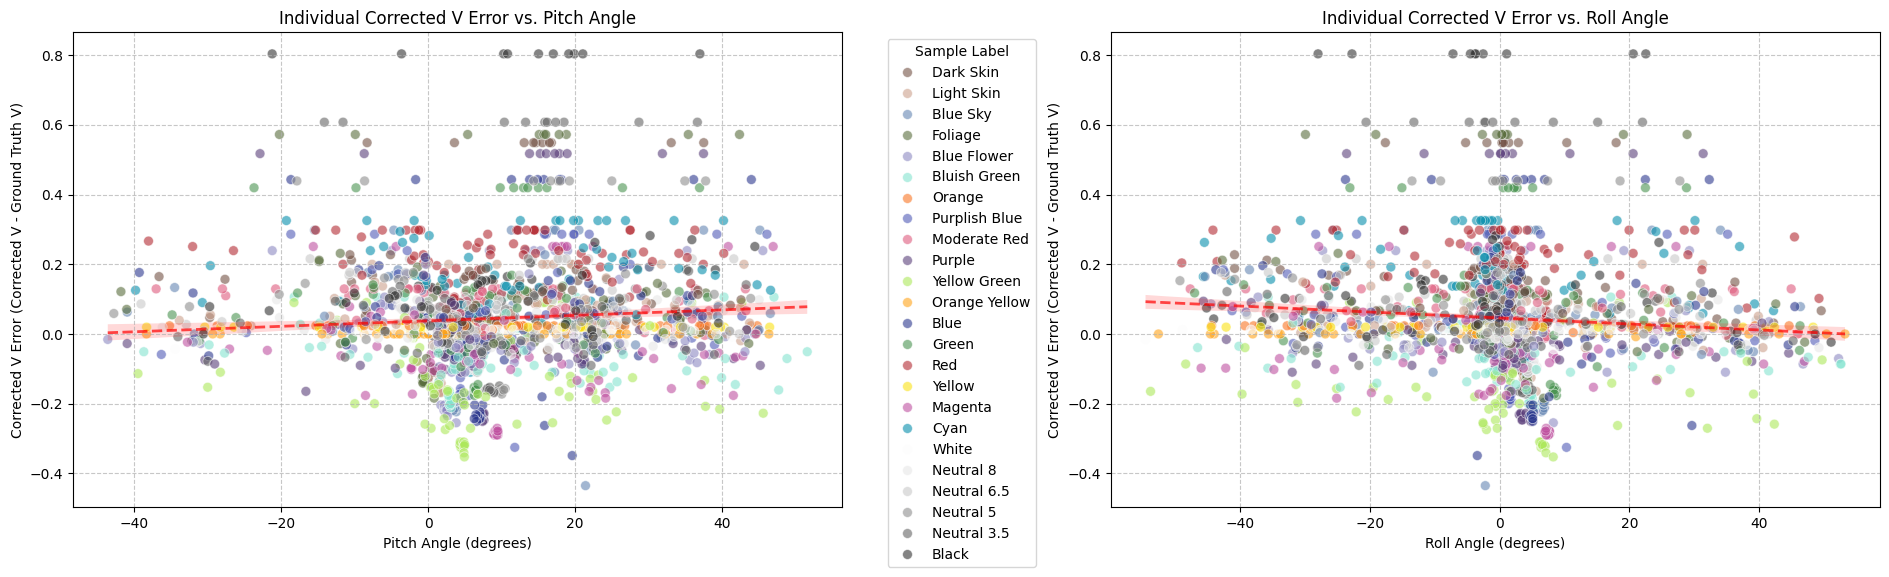

### Head of DataFrame with new individual_H_error_corr column:

   sample_number  capture_index  gt_H_individual  corrected_r2_H_individual  \
0              1              0         0.047101                        0.0   
1              1              1         0.047101                        0.0   
2              1              2         0.047101                        0.0   
3              1              3         0.047101                        0.0   
4              1              4         0.047101                        0.0   

   individual_H_error_corr  
0                -0.047101  
1                -0.047101  
2                -0.047101  
3                -0.047101  
4                -0.047101  
Pearson correlation between individual_H_error_corr and pitch: -0.0920
Pearson correlation between individual_H_error_corr and roll: -0.0099


### Head of DataFrame with new individual_S_error_corr column:

   sample_number  capture_index  gt_S_individual  corrected_r2_S_individual  \
0              1              0              0.4                        0.0   
1              1              1              0.4                        0.0   
2              1              2              0.4                        0.0   
3              1              3              0.4                        0.0   
4              1              4              0.4                        0.0   

   individual_S_error_corr  
0                     -0.4  
1                     -0.4  
2                     -0.4  
3                     -0.4  
4                     -0.4  
Pearson correlation between individual_S_error_corr and pitch: -0.1978
Pearson correlation between individual_S_error_corr and roll: 0.0078


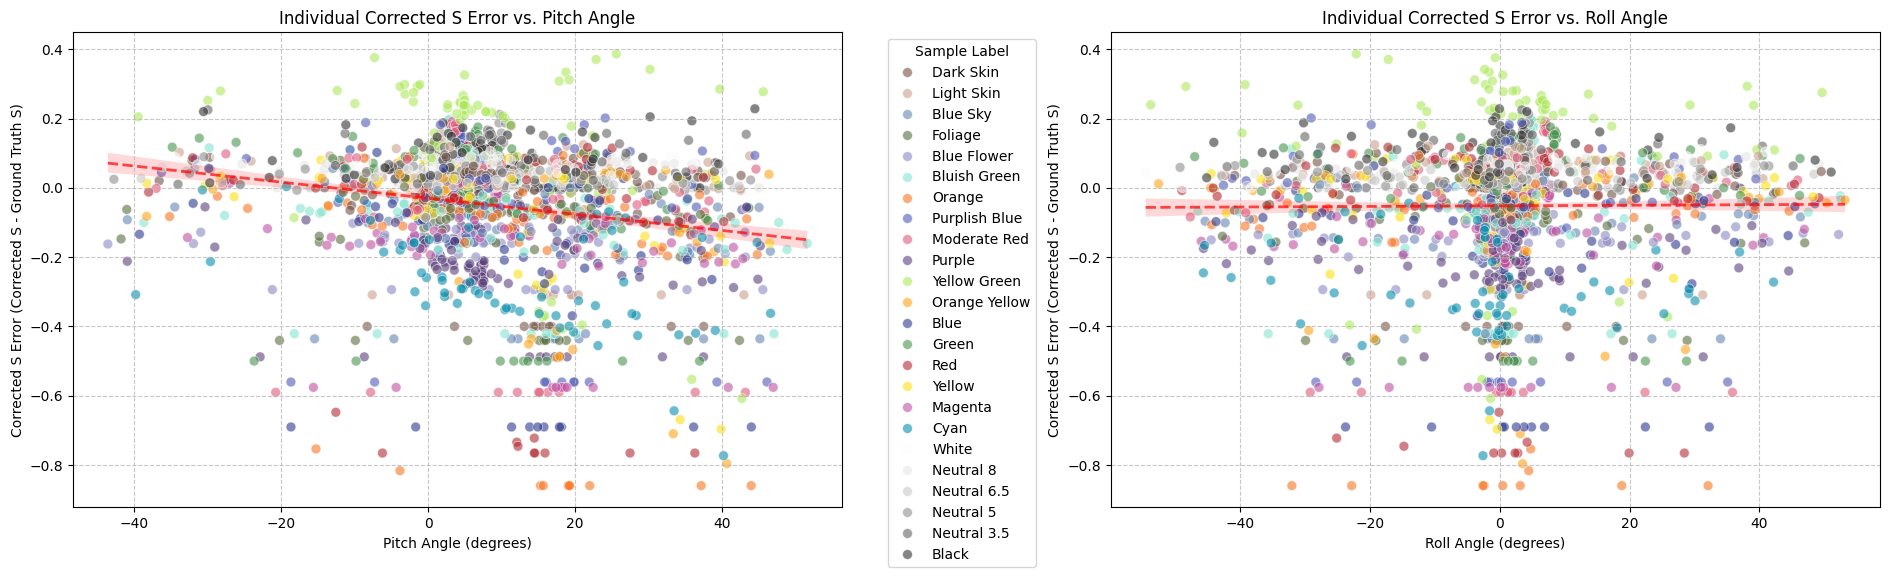

In [ ]:
HSV_error(df)

In [ ]:
# Perform test
red_samples = df[df['label'] == 'Red']
hue_errors_red = red_samples['individual_H_error_corr']
print("### Extracted 'individual_H_error_corr' for Red samples:")

# Perform one-sample t-test
# H0: mu = 0
# H1: mu < 0 (left-tailed test)

t_statistic, p_value = stats.ttest_1samp(hue_errors_red, 0, alternative='less')

print(f"### One-Sample t-test for 'individual_H_error_corr' in 'Red' samples (against mu=0)\n")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print(f"\nSince the P-value ({p_value:.4e}) is less than alpha ({alpha}), we reject the null hypothesis.")
    print("Conclusion: The mean 'individual_H_error_corr' for 'Red' samples is significantly less than 0.")
else:
    print(f"\nSince the P-value ({p_value:.4e}) is greater than alpha ({alpha}), we fail to reject the null hypothesis.")
    print("Conclusion: There is no sufficient evidence to conclude that the mean 'individual_H_error_corr' for 'Red' samples is less than 0.")


### Extracted 'individual_H_error_corr' for Red samples:
### One-Sample t-test for 'individual_H_error_corr' in 'Red' samples (against mu=0)

T-statistic: -39.0255
P-value: 1.0806e-53

Since the P-value (1.0806e-53) is less than alpha (0.05), we reject the null hypothesis.
Conclusion: The mean 'individual_H_error_corr' for 'Red' samples is significantly less than 0.


In [ ]:
# Perform test
yellowGreen_samples = df[df['label'] == 'Yellow Green']
hue_errors_yG = yellowGreen_samples['individual_S_error_corr']
print("### Extracted 'individual_S_error_corr' for Red samples:")

# Perform one-sample t-test
# H0: mu = 0
# H1: mu < 0 (left-tailed test)

t_statistic, p_value = stats.ttest_1samp(hue_errors_yG, 0, alternative='greater')

print(f"### One-Sample t-test for 'individual_S_error_corr' in 'Red' samples (against mu=0)\n")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print(f"\nSince the P-value ({p_value:.4e}) is less than alpha ({alpha}), we reject the null hypothesis.")
    print("Conclusion: The mean 'individual_S_error_corr' for 'YGreen' samples is significantly greater than 0.")
else:
    print(f"\nSince the P-value ({p_value:.4e}) is greater than alpha ({alpha}), we fail to reject the null hypothesis.")
    print("Conclusion: There is no sufficient evidence to conclude that the mean 'individual_S_error_corr' for 'YGreen' samples is greater than 0.")


### Extracted 'individual_S_error_corr' for Red samples:
### One-Sample t-test for 'individual_S_error_corr' in 'Red' samples (against mu=0)

T-statistic: 5.2691
P-value: 5.7891e-07

Since the P-value (5.7891e-07) is less than alpha (0.05), we reject the null hypothesis.
Conclusion: The mean 'individual_S_error_corr' for 'YGreen' samples is significantly greater than 0.
